## Import Libraries

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.patches as patches

## Data dir

In [18]:
images = sorted(os.listdir("/content/drive/MyDrive/Dataset/archive (5)/PennFudanPed/PNGImages"))
masks = sorted(os.listdir("/content/drive/MyDrive/Dataset/archive (5)/PennFudanPed/PedMasks"))

In [19]:
idx = 0
img = Image.open(
    "/content/drive/MyDrive/Dataset/archive (5)/PennFudanPed/PNGImages/"
    + images[idx]
).convert("RGB")

mask = Image.open(
    "/content/drive/MyDrive/Dataset/archive (5)/PennFudanPed/PedMasks/"
    + masks[idx]
)


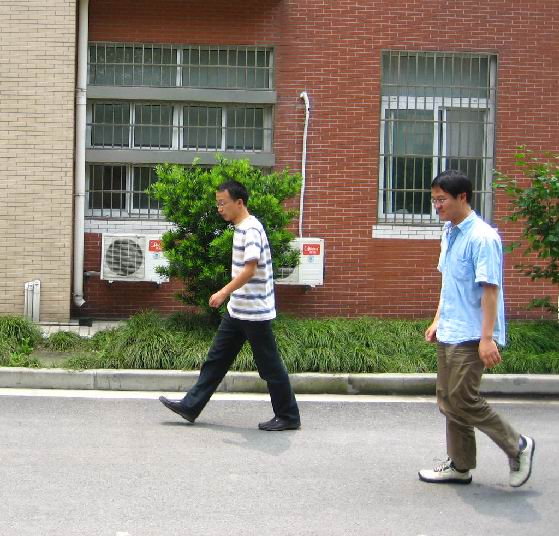

In [20]:
img

In [21]:
np.unique(mask)

array([0, 1, 2], dtype=uint8)

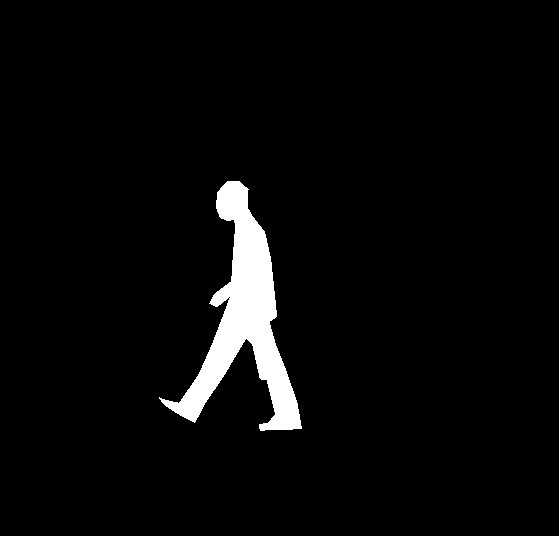

In [22]:
Image.fromarray(np.array(mask) == 1)

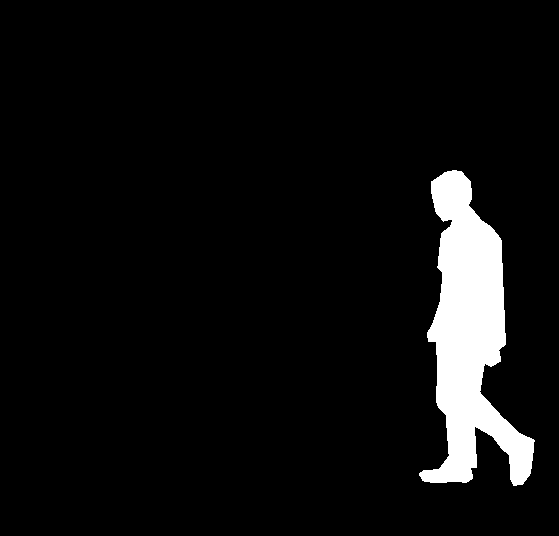

In [23]:
Image.fromarray(np.array(mask) == 2)

## CustomDataset

In [24]:

class PennFudanDataset(torch.utils.data.Dataset):
    """
    Penn-Fudan Database for Pedestrian Detection and Segmentation
    Dataset structure:
    - PennFudanPed/
        - PNGImages/
        - PedMasks/
    """
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # Load all image and mask files
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")

        # Load mask (note: masks are not RGB, they are grayscale with instance IDs)
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # Instances are encoded as different colors
        obj_ids = np.unique(mask)
        # Remove background (ID 0)
        obj_ids = obj_ids[1:]

        # Split the mask into binary masks for each instance
        masks = mask == obj_ids[:, None, None]

        # Get bounding boxes from masks
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)  # Only one class: pedestrian
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # All instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


## Data Transforms

In [25]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class ToTensor:
    def __call__(self, image, target):
        image = T.functional.to_tensor(image)
        return image, target


class RandomHorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if torch.rand(1) < self.prob:
            image = T.functional.hflip(image)
            if "boxes" in target:
                bbox = target["boxes"]
                bbox[:, [0, 2]] = image.shape[-1] - bbox[:, [2, 0]]
                target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
        return image, target


def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

## Collate Function

In [26]:
def collate_fn(batch):
    """
    Custom collate function for batching images with different sizes
    """
    return tuple(zip(*batch))

## Model Creation

In [27]:
def get_model_instance_segmentation(num_classes):
    """
    Load pretrained Mask R-CNN model and modify for our dataset

    Args:
        num_classes: Number of classes (background + object classes)
                     For Penn-Fudan: 2 (background + pedestrian)
    """
    # Load pretrained model on COCO
    model = maskrcnn_resnet50_fpn(pretrained=True)

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model


## TRAINING FUNCTION

In [28]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    """Train for one epoch"""
    model.train()

    total_loss = 0
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        if i % 10 == 0:
            print(f"Epoch [{epoch}], Step [{i}/{len(data_loader)}], Loss: {losses.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")
    return avg_loss


## Evaluation and Visualization

In [29]:
@torch.no_grad()
def evaluate_and_visualize(model, dataset, device, num_images=5, threshold=0.5):
    """
    Evaluate model and visualize predictions

    Args:
        model: Trained Mask R-CNN model
        dataset: Dataset to evaluate on
        device: Device to run on
        num_images: Number of images to visualize
        threshold: Confidence threshold for predictions
    """
    model.eval()

    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)

    for idx in range(min(num_images, len(dataset))):
        img, target = dataset[idx]

        # Predict
        prediction = model([img.to(device)])[0]

        # Convert image to numpy for visualization
        img_np = img.permute(1, 2, 0).cpu().numpy()

        # Plot original image
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f'Original Image {idx}')
        axes[idx, 0].axis('off')

        # Plot ground truth
        axes[idx, 1].imshow(img_np)
        gt_boxes = target['boxes'].cpu().numpy()
        for box in gt_boxes:
            rect = patches.Rectangle(
                (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                linewidth=2, edgecolor='g', facecolor='none'
            )
            axes[idx, 1].add_patch(rect)
        axes[idx, 1].set_title(f'Ground Truth ({len(gt_boxes)} objects)')
        axes[idx, 1].axis('off')

        # Plot predictions
        axes[idx, 2].imshow(img_np)

        # Filter predictions by threshold
        scores = prediction['scores'].cpu().numpy()
        boxes = prediction['boxes'].cpu().numpy()
        masks = prediction['masks'].cpu().numpy()

        keep = scores > threshold
        boxes = boxes[keep]
        masks = masks[keep]
        scores = scores[keep]

        # Draw boxes and masks
        combined_mask = np.zeros_like(img_np)
        for i, (box, mask, score) in enumerate(zip(boxes, masks, scores)):
            # Draw bounding box
            rect = patches.Rectangle(
                (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                linewidth=2, edgecolor='r', facecolor='none'
            )
            axes[idx, 2].add_patch(rect)

            # Add score text
            axes[idx, 2].text(
                box[0], box[1]-5, f'{score:.2f}',
                color='red', fontsize=12, weight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
            )

            # Overlay mask
            mask_binary = mask[0] > 0.5
            combined_mask[mask_binary] = [1, 0, 0]  # Red mask

        axes[idx, 2].imshow(combined_mask, alpha=0.3)
        axes[idx, 2].set_title(f'Predictions ({len(boxes)} objects)')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
    print("Visualization saved as 'predictions.png'")
    plt.show()


Using device: cuda
Loading datasets...
Training samples: 136
Validation samples: 34
Creating model...

Starting training...
Epoch [0], Step [0/68], Loss: 4.6542
Epoch [0], Step [10/68], Loss: 0.5102
Epoch [0], Step [20/68], Loss: 0.3193
Epoch [0], Step [30/68], Loss: 0.3773
Epoch [0], Step [40/68], Loss: 0.3989
Epoch [0], Step [50/68], Loss: 0.2778
Epoch [0], Step [60/68], Loss: 0.2093
Epoch [0] Average Loss: 0.5456
Epoch [1], Step [0/68], Loss: 0.2831
Epoch [1], Step [10/68], Loss: 0.2179
Epoch [1], Step [20/68], Loss: 0.2885
Epoch [1], Step [30/68], Loss: 0.2833
Epoch [1], Step [40/68], Loss: 0.2102
Epoch [1], Step [50/68], Loss: 0.2301
Epoch [1], Step [60/68], Loss: 0.1715
Epoch [1] Average Loss: 0.2665
Epoch [2], Step [0/68], Loss: 0.2001
Epoch [2], Step [10/68], Loss: 0.3052
Epoch [2], Step [20/68], Loss: 0.2041
Epoch [2], Step [30/68], Loss: 0.2108
Epoch [2], Step [40/68], Loss: 0.2284
Epoch [2], Step [50/68], Loss: 0.2278
Epoch [2], Step [60/68], Loss: 0.2554
Epoch [2] Average L

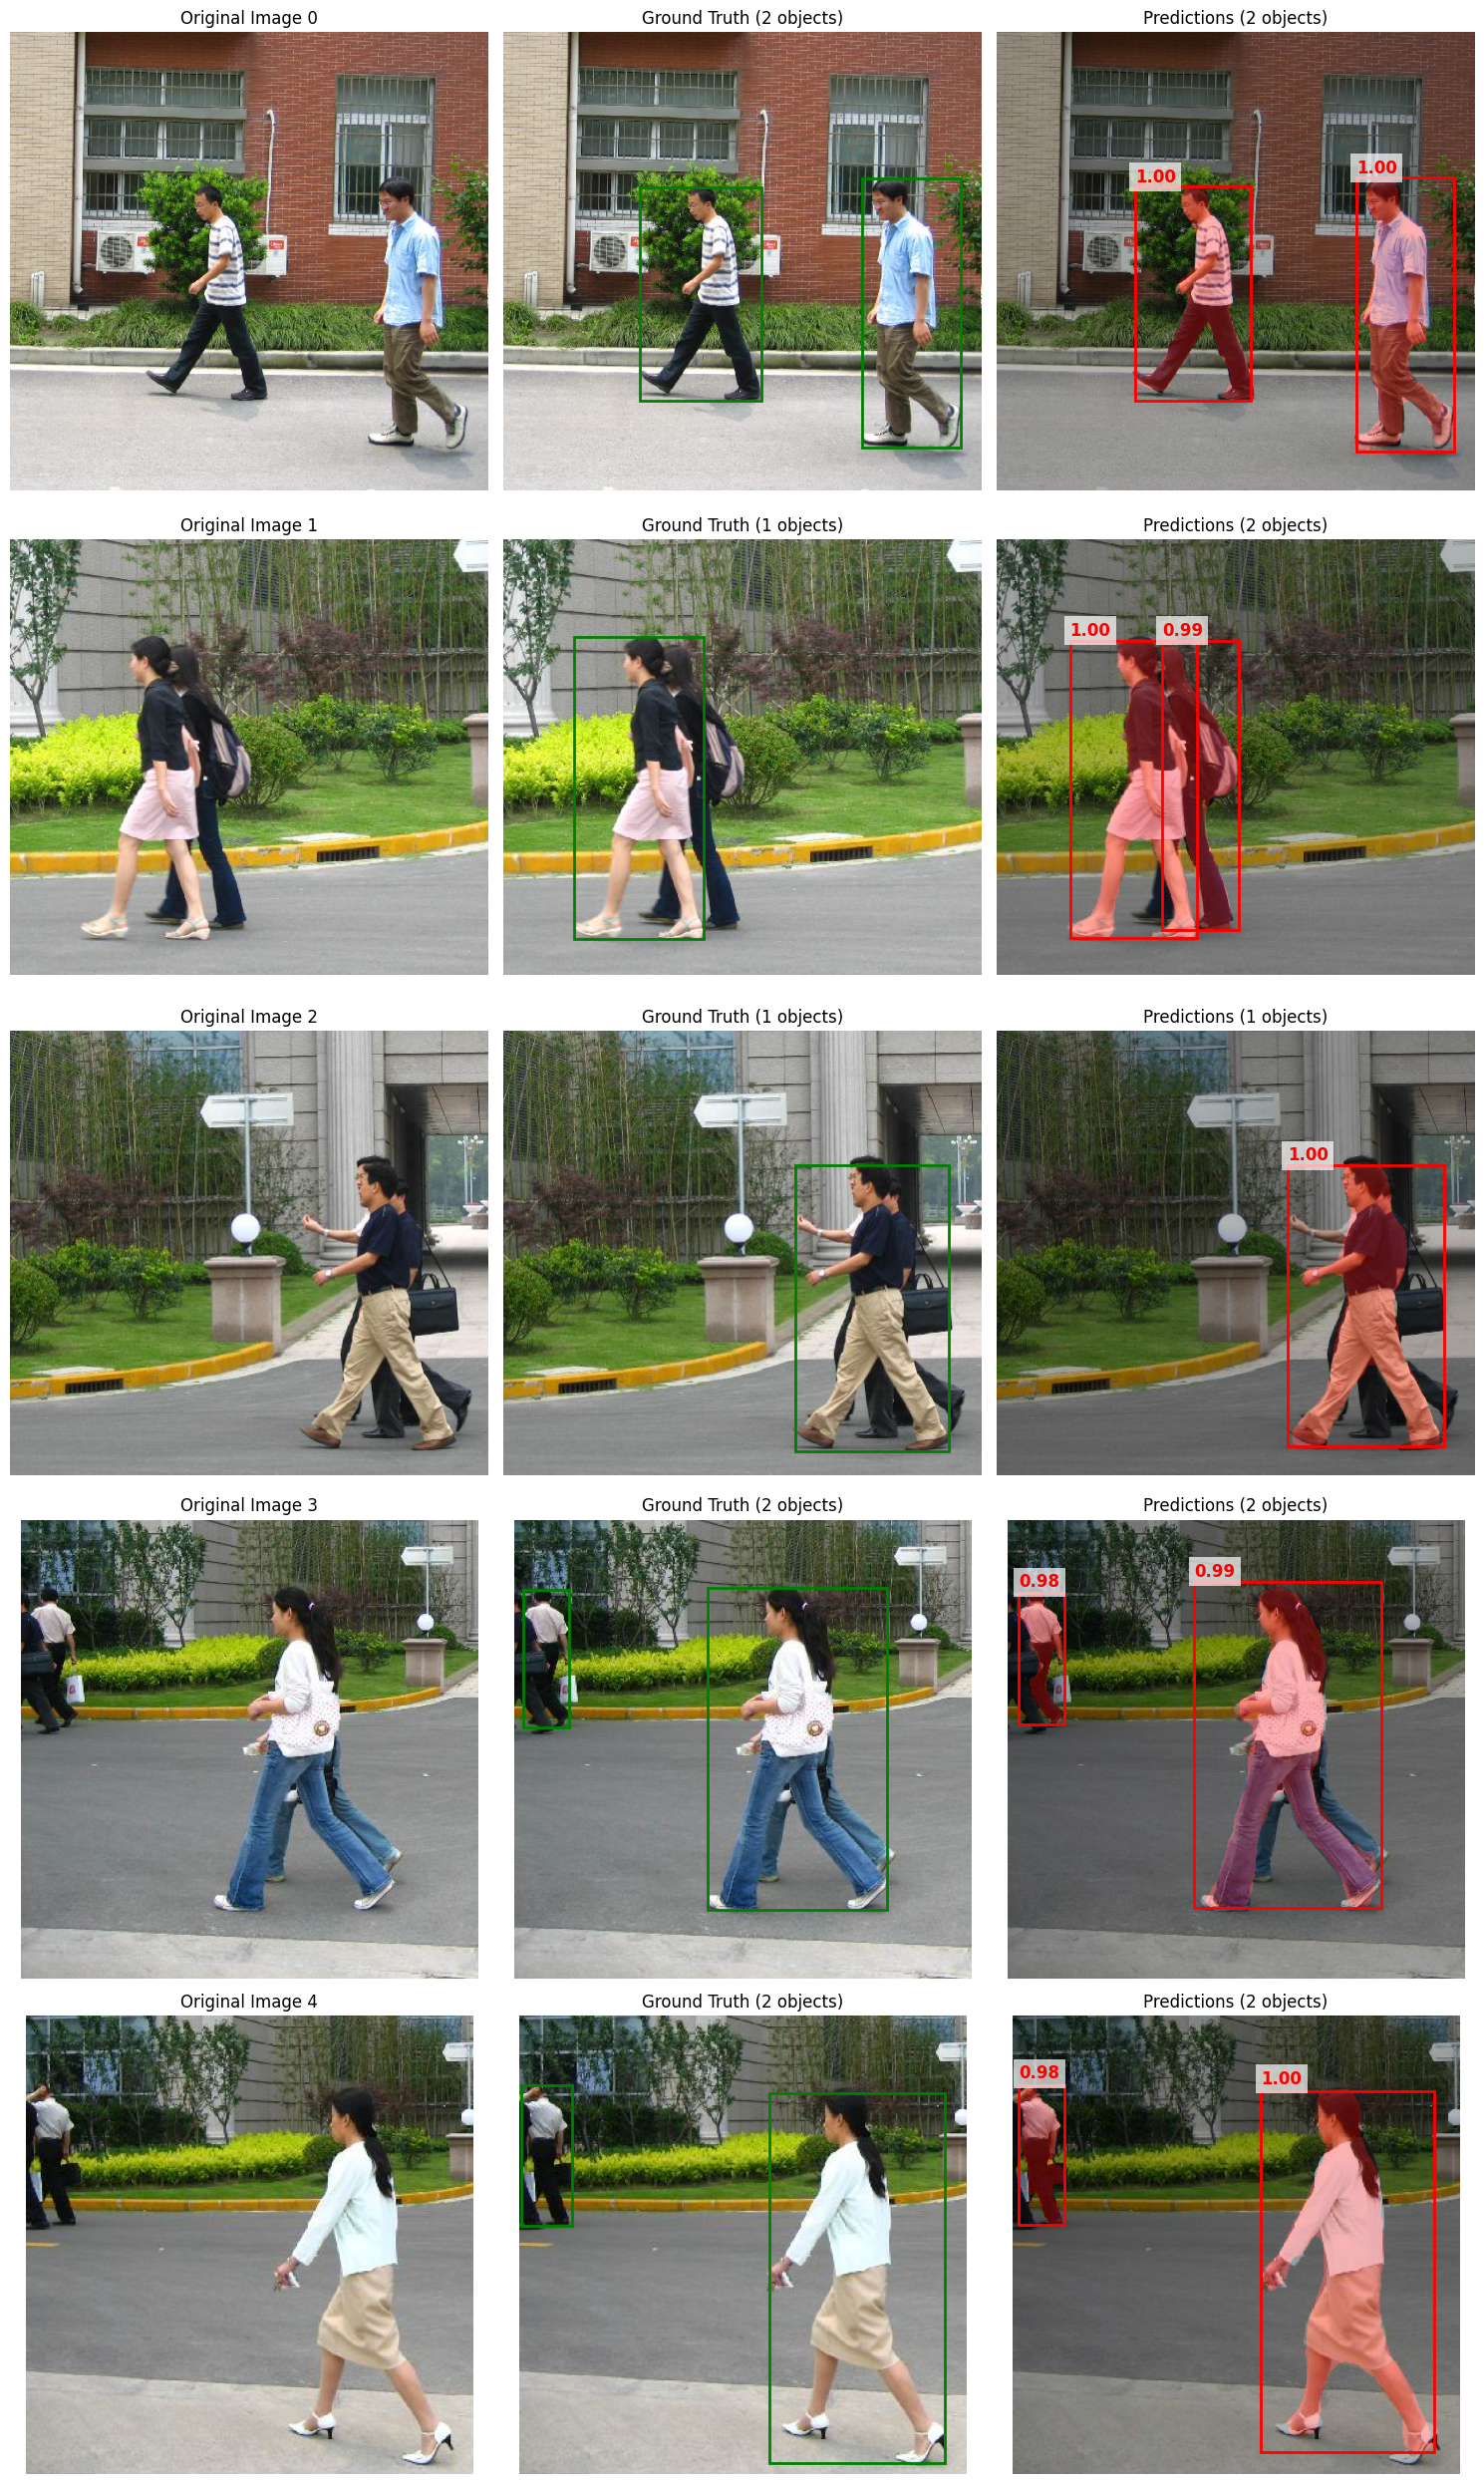

In [34]:
# Configuration
DATA_PATH = "/content/drive/MyDrive/Dataset/archive (5)/PennFudanPed"  # Update this path to your dataset location
BATCH_SIZE = 2
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
NUM_CLASSES = 2  # background + pedestrian

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create datasets
print("Loading datasets...")
dataset = PennFudanDataset(DATA_PATH, get_transform(train=True))
dataset_test = PennFudanDataset(DATA_PATH, get_transform(train=False))

# Split dataset into train and test
indices = torch.randperm(len(dataset)).tolist()
split = int(0.8 * len(dataset))
dataset_train = torch.utils.data.Subset(dataset, indices[:split])
dataset_val = torch.utils.data.Subset(dataset_test, indices[split:])

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_val)}")

# Create data loaders
data_loader_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

data_loader_val = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# Create model
print("Creating model...")
model = get_model_instance_segmentation(NUM_CLASSES)
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=0.0005
)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# Training loop
print("\nStarting training...")
for epoch in range(NUM_EPOCHS):
    # Train
    train_loss = train_one_epoch(
        model, optimizer, data_loader_train, device, epoch
    )

    # Update learning rate
    lr_scheduler.step()

    # Save checkpoint
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, f'maskrcnn_pennfudan_epoch_{epoch+1}.pth')
        print(f"Checkpoint saved: maskrcnn_pennfudan_epoch_{epoch+1}.pth")

# Save final model
torch.save(model.state_dict(), 'maskrcnn_pennfudan_final.pth')
print("\nTraining completed! Final model saved.")

# Visualize predictions on validation set
print("\nGenerating visualizations...")
val_dataset = PennFudanDataset(DATA_PATH, get_transform(train=False))
evaluate_and_visualize(model, val_dataset, device, num_images=5, threshold=0.5)

In [35]:
def predict_single_image(model, image_path, device, threshold=0.5):
    """
    Run inference on a single image

    Args:
        model: Trained Mask R-CNN model
        image_path: Path to image
        device: Device to run on
        threshold: Confidence threshold
    """
    model.eval()

    # Load and transform image
    img = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img).to(device)

    # Predict
    with torch.no_grad():
        prediction = model([img_tensor])[0]

    # Filter predictions
    keep = prediction['scores'] > threshold
    boxes = prediction['boxes'][keep].cpu().numpy()
    masks = prediction['masks'][keep].cpu().numpy()
    scores = prediction['scores'][keep].cpu().numpy()
    labels = prediction['labels'][keep].cpu().numpy()

    # Visualize
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img)

    for box, mask, score in zip(boxes, masks, scores):
        # Draw box
        rect = patches.Rectangle(
            (box[0], box[1]), box[2]-box[0], box[3]-box[1],
            linewidth=3, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        # Add score
        ax.text(
            box[0], box[1]-10, f'{score:.2f}',
            color='red', fontsize=14, weight='bold',
            bbox=dict(facecolor='white', alpha=0.8)
        )

        # Overlay mask
        mask_binary = mask[0] > 0.5
        colored_mask = np.zeros((*mask_binary.shape, 3))
        colored_mask[mask_binary] = [1, 0, 0]
        ax.imshow(colored_mask, alpha=0.4)

    ax.axis('off')
    ax.set_title(f'Detected {len(boxes)} pedestrians')
    plt.tight_layout()
    plt.savefig('prediction_single.png', dpi=150, bbox_inches='tight')
    plt.show()

    return boxes, masks, scores, labels

In [38]:
predict_single_image(model, "/content/drive/MyDrive/Dataset/archive (5)/PennFudanPed/PNGImages/PennPed00095.png", device, threshold=0.5)

(array([[193.49738 ,  50.717255, 301.142   , 339.9245  ],
        [316.73566 ,  56.523415, 428.23584 , 334.94092 ]], dtype=float32),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32),
 array([0.99787915, 0.9977621 ], dtype=float32),
 array([1, 1]))